In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
file_path = "../data/icon_summary_annotated.csv"

df = pd.read_csv(
    file_path,
    delimiter=",",
    encoding="utf-8",
    header=0
)

In [4]:
df.head()

,nodes,taskspernode,threadspertask,iconsteps,cpufreq,slurm_job_id,cnt,tpe,tlb,tce,tse,tte,tmpe,tmlb,tmce,tmse,tmte,tope,tolb,toce,tose,tote,epe,elb,ece,ese,ete,empe,emlb,emce,emse,emte,eope,eolb,eoce,eose,eote,total_time
0,1,4,24,1,1000000,60244226,1,0.805,0.938,0.858,0.937,0.916,0.916,0.952,0.962,0.993,0.969,0.879,0.985,0.892,0.944,0.945,0.812,0.926,0.876,0.997,0.879,0.972,0.964,1.008,1.001,1.008,0.835,0.961,0.869,0.996,0.873,85.690
1,1,4,24,1,1500000,60244227,1,0.799,0.945,0.845,0.929,0.910,0.917,0.960,0.955,0.991,0.964,0.871,0.984,0.885,0.938,0.944,0.811,0.965,0.841,0.948,0.886,0.962,0.987,0.975,0.998,0.976,0.844,0.979,0.862,0.950,0.908,75.614
2,1,4,24,1,2000000,60244228,1,0.809,0.940,0.861,0.940,0.916,0.927,0.965,0.961,0.993,0.967,0.872,0.974,0.896,0.946,0.947,0.823,0.932,0.883,0.986,0.895,0.960,0.976,0.983,0.996,0.987,0.857,0.955,0.897,0.990,0.907,67.480
3,1,4,24,1,2500000,60244229,1,0.815,0.950,0.858,0.941,0.912,0.921,0.960,0.959,0.995,0.964,0.885,0.989,0.895,0.946,0.946,0.829,0.969,0.856,0.959,0.893,0.921,0.977,0.942,0.999,0.943,0.901,0.992,0.908,0.960,0.947,37.187
4,1,4,24,1,3000000,60244230,1,0.593,0.667,0.889,0.945,0.941,0.735,0.755,0.974,0.996,0.978,0.807,0.883,0.913,0.949,0.962,0.674,0.768,0.878,0.955,0.919,0.936,0.850,1.102,1.002,1.100,0.720,0.904,0.797,0.953,0.836,37.435


In [5]:
df.shape

(168, 38)

In [6]:
df.columns[(df > 1).any(axis=0)]
# PE, CommE, SerE, TE
# MPI SerE
# OMP PE, OMP CommE, OMP SerE, OMP TE

Index(['taskspernode', 'threadspertask', 'iconsteps', 'cpufreq',
       'slurm_job_id', 'ese', 'emce', 'emse', 'emte', 'eolb', 'eose',
       'total_time'],
      dtype='object')

In [7]:
# df_without_overflow = df[(df["total_time"] > 748)]
# df_without_overflow
df_without_overflow = df

In [8]:
df_without_overflow.shape

(168, 38)

In [9]:
# df = df[(df["taskspernode"] != 96)]
# df.shape

In [10]:
def aligned_values_from_df(dframe, cpufreqs, column):
    vals = []
    for f in cpufreqs:
        rows = dframe[dframe["cpufreq"] == f]
        if len(rows) == 0:
            vals.append(np.nan)
        else:
            vals.append(rows.iloc[0][column])
    return np.array(vals, dtype=float)

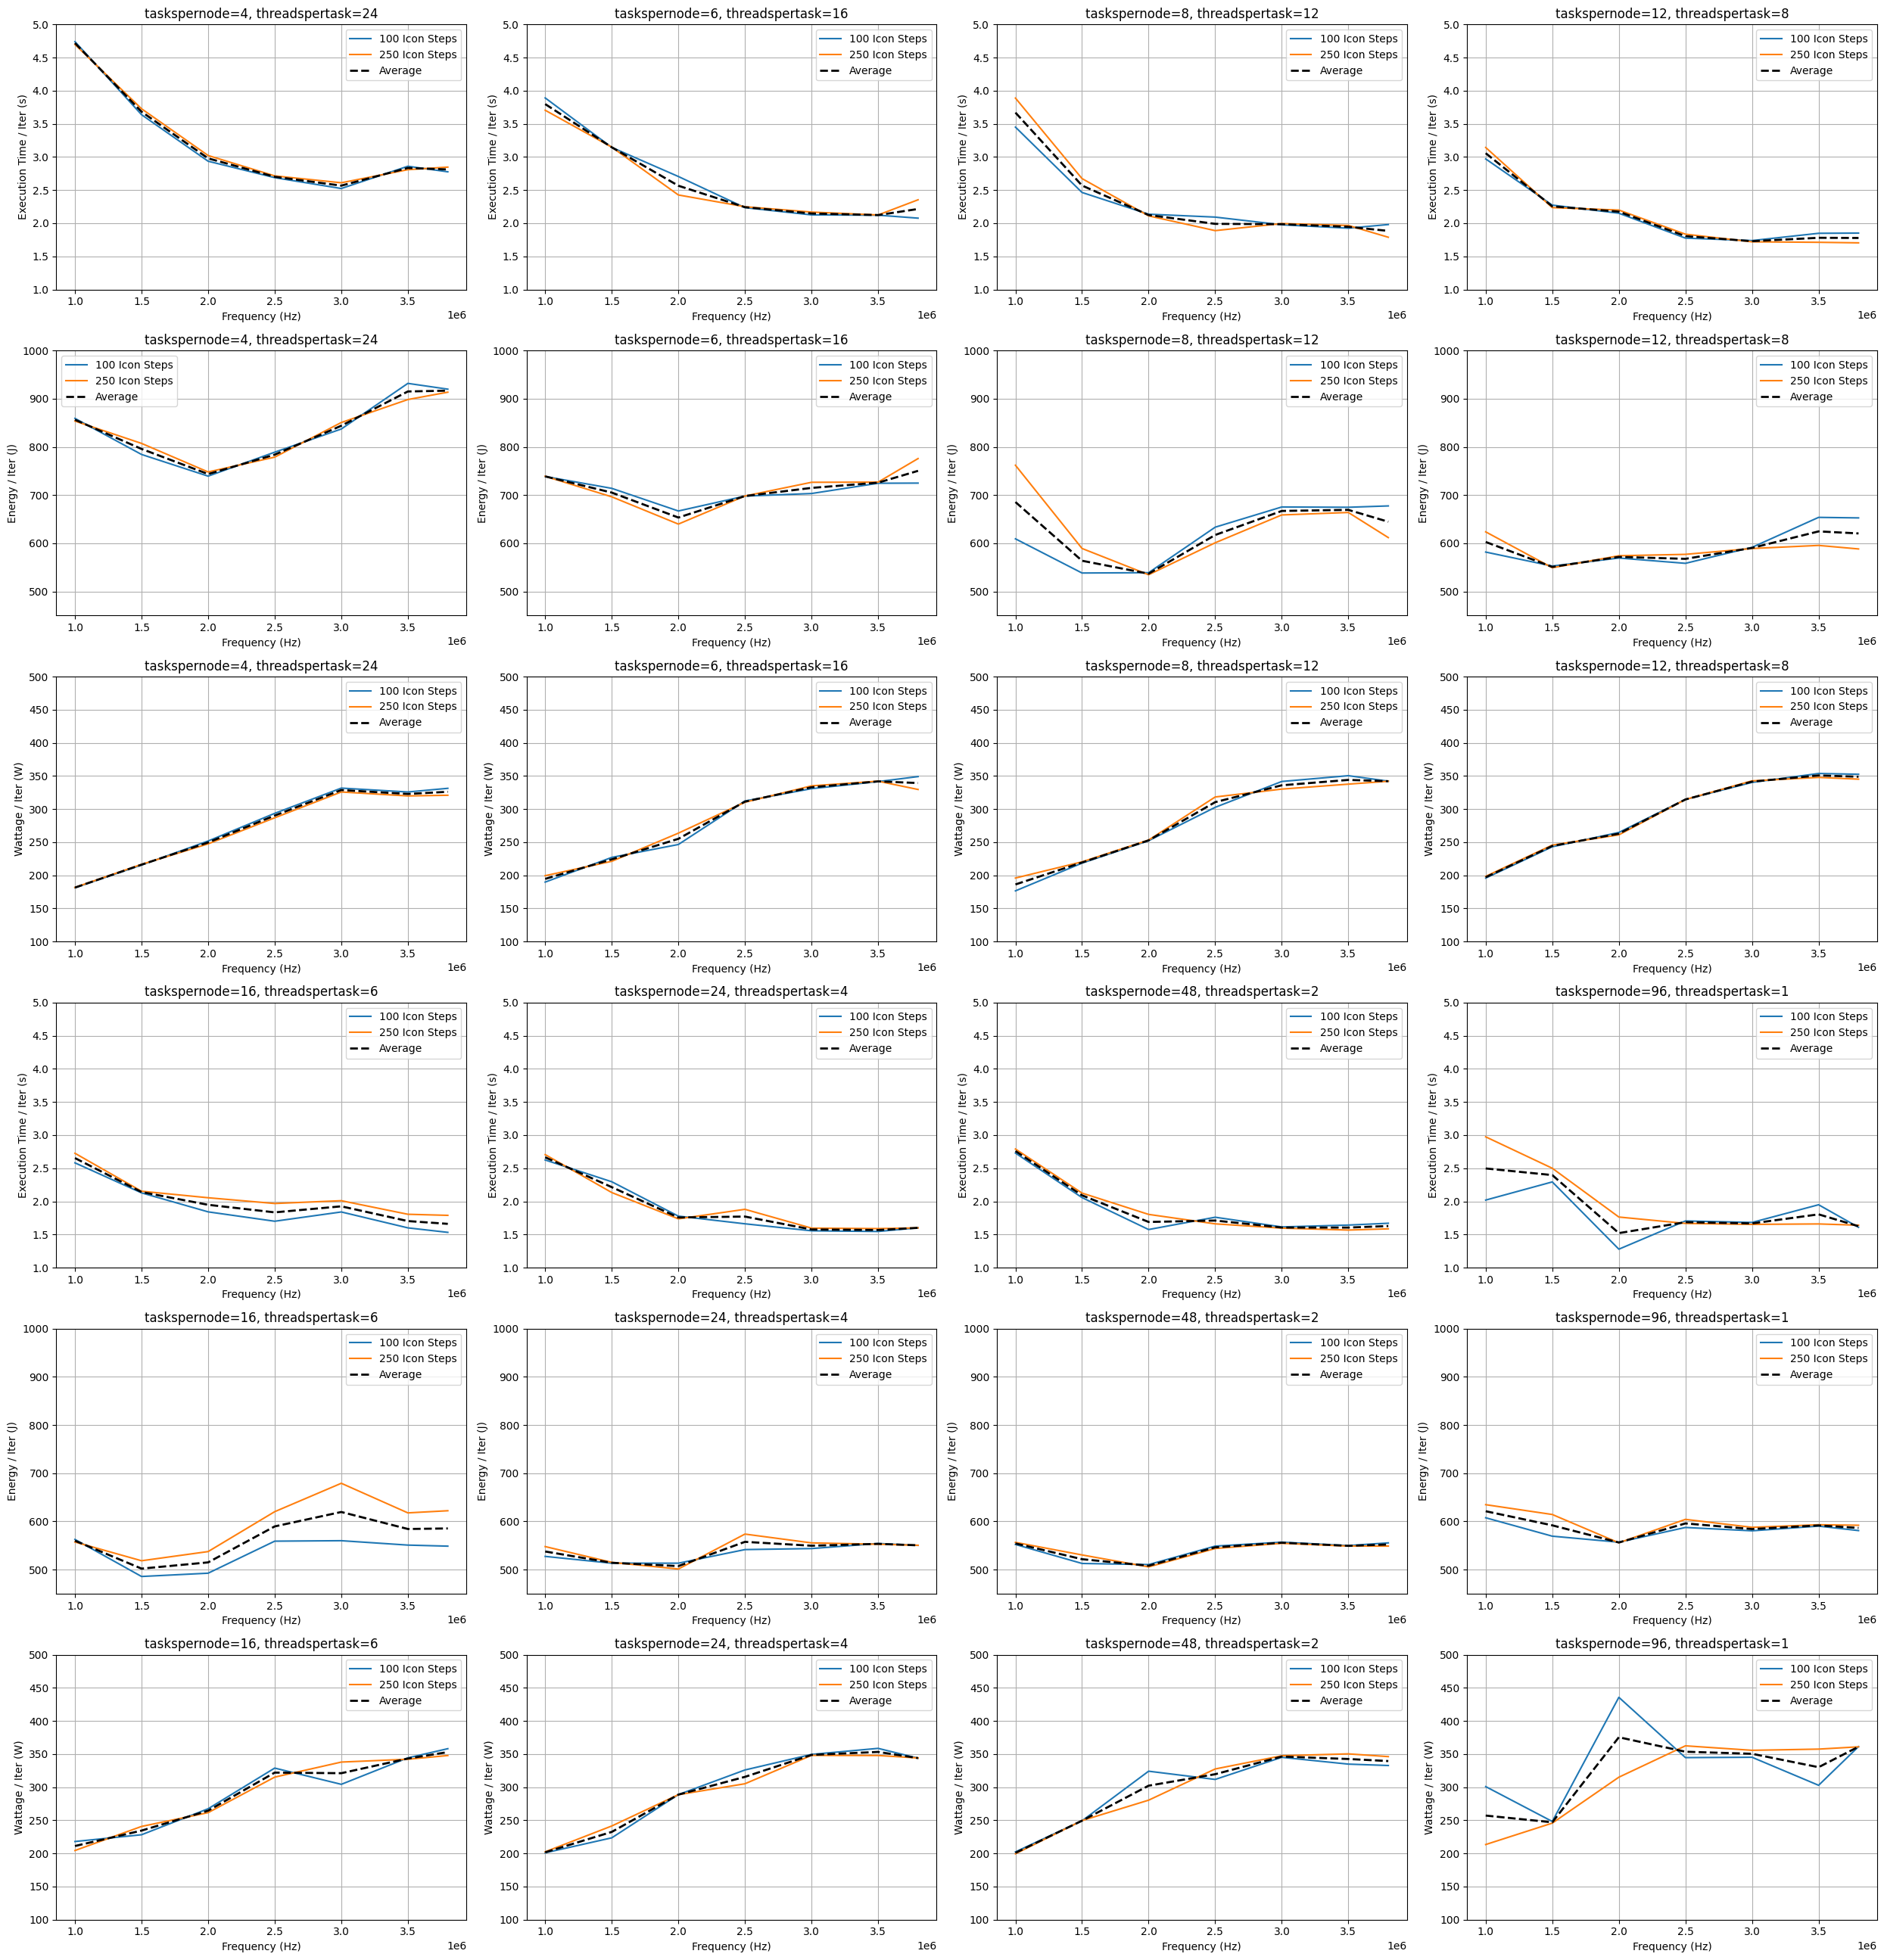

[SAVED] ../results/icon_cpufreq_time_energy_wattage.png


In [11]:
ncols = 4
avg_steps = [100, 250]
tasks = sorted(set(df["taskspernode"].unique()).union(set(df_without_overflow["taskspernode"].unique())))
icon_steps_all = sorted(df["iconsteps"].unique())

nrows = 3 * ((len(tasks) + ncols - 1) // ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(25, 13 * ((nrows)//3)), squeeze=False)

for t_idx, task in enumerate(tasks):
    col = t_idx % ncols
    block = t_idx // ncols
    row_base = 3 * block

    cpufreqs = sorted(df_without_overflow.loc[df_without_overflow["taskspernode"] == task, "cpufreq"].unique())
    if len(cpufreqs) == 0:
        cpufreqs = sorted(df.loc[df["taskspernode"] == task, "cpufreq"].unique())
    if len(cpufreqs) == 0:
        print(f"[WARN] No cpufreqs for task={task} — skipping")
        continue
    cpufreqs = np.array(cpufreqs)

    # --- RUNTIME ---
    base_rt_df = df[(df["taskspernode"] == task) & (df["iconsteps"] == 1)]
    base_runtime = aligned_values_from_df(base_rt_df, cpufreqs, "total_time")
    runtime_store = {}

    if np.isnan(base_runtime).all():
        print(f"[WARN] base runtime all NaN for task={task}")

    for step in icon_steps_all:
        if step == 1:
            continue
        step_df = df[(df["taskspernode"] == task) & (df["iconsteps"] == step)]
        total_time_arr = aligned_values_from_df(step_df, cpufreqs, "total_time")

        if np.isnan(base_runtime).any() or np.isnan(total_time_arr).any():
            print(f"[INFO] skipping runtime step={step} for task={task} (missing base or step data)")
            continue

        runtime_per_iter = (total_time_arr - base_runtime) / (step - 1)
        runtime_store[step] = runtime_per_iter
        axs[row_base, col].plot(cpufreqs, runtime_per_iter, label=f"{step} Icon Steps")

    if all(s in runtime_store for s in avg_steps):
        y_avg = np.mean(np.vstack([runtime_store[s] for s in avg_steps]), axis=0)
        axs[row_base, col].plot(cpufreqs, y_avg, linestyle="--", linewidth=2, color="k", label=f"Average")
    else:
        found = [s for s in avg_steps if s in runtime_store]
        print(f"[INFO] runtime avg missing for task={task}: found {len(found)}/{len(avg_steps)} -> {found}")

    axs[row_base, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
    axs[row_base, col].set_xlabel('Frequency (Hz)')
    axs[row_base, col].set_ylabel('Execution Time / Iter (s)')
    axs[row_base, col].set_ylim([1, 5])
    axs[row_base, col].legend()
    axs[row_base, col].grid(True)

    # --- ENERGY ---
    base_energy = []
    for f in cpufreqs:
        path = f"../data/icon_reports/{task}_ranks_{96 // task}_threads_{f}_hz_1_steps.csv"
        if os.path.exists(path):
            single = pd.read_csv(path, delimiter=",", encoding="utf-8", header=0)
            base_energy.append(single["total_energy"].max())
        else:
            base_energy.append(np.nan)
    base_energy = np.array(base_energy, dtype=float)
    if np.isnan(base_energy).all():
        print(f"[WARN] base energy all NaN for task={task} (missing CSVs)")

    energy_store = {}
    for step in icon_steps_all:
        if step == 1:
            continue

        total_energy_list = []
        for f in cpufreqs:
            path = f"../data/icon_reports/{task}_ranks_{96 // task}_threads_{f}_hz_{step}_steps.csv"
            if os.path.exists(path):
                single_run_df = pd.read_csv(path, delimiter=",", encoding="utf-8", header=0)
                total_energy_list.append(single_run_df["total_energy"].max())
            else:
                total_energy_list.append(np.nan)

        total_energy_arr = np.array(total_energy_list, dtype=float)
        if np.isnan(base_energy).any() or np.isnan(total_energy_arr).any():
            print(f"[INFO] skipping energy step={step} for task={task} (missing base CSVs or step CSVs)")
            continue

        energy_per_iter = (total_energy_arr - base_energy) / (step - 1)
        energy_store[step] = energy_per_iter
        axs[row_base + 1, col].plot(cpufreqs, energy_per_iter, label=f"{step} Icon Steps")

    if all(s in energy_store for s in avg_steps):
        y_avg_energy = np.mean(np.vstack([energy_store[s] for s in avg_steps]), axis=0)
        axs[row_base + 1, col].plot(cpufreqs, y_avg_energy, linestyle="--", linewidth=2, color="k", label=f"Average")
    else:
        found = [s for s in avg_steps if s in energy_store]
        print(f"[INFO] energy avg missing for task={task}: found {len(found)}/{len(avg_steps)} -> {found}")

    axs[row_base + 1, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
    axs[row_base + 1, col].set_xlabel('Frequency (Hz)')
    axs[row_base + 1, col].set_ylabel('Energy / Iter (J)')
    axs[row_base + 1, col].set_ylim([450, 1000])
    axs[row_base + 1, col].legend()
    axs[row_base + 1, col].grid(True)

    wattage_store = {}
    for step in sorted(set(runtime_store.keys()).intersection(set(energy_store.keys()))):
        rt = np.array(runtime_store[step], dtype=float)
        en = np.array(energy_store[step], dtype=float)
        with np.errstate(divide='ignore', invalid='ignore'):
            watt = np.where(rt > 0, en / rt, np.nan)
        wattage_store[step] = watt
        axs[row_base + 2, col].plot(cpufreqs, watt, label=f"{step} Icon Steps")

    if all(s in wattage_store for s in avg_steps):
        y_avg_w = np.mean(np.vstack([wattage_store[s] for s in avg_steps]), axis=0)
        axs[row_base + 2, col].plot(cpufreqs, y_avg_w, linestyle="--", linewidth=2, color="k", label=f"Average")
    else:
        found = [s for s in avg_steps if s in wattage_store]
        print(f"[INFO] wattage avg missing for task={task}: found {len(found)}/{len(avg_steps)} -> {found}")

    axs[row_base + 2, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
    axs[row_base + 2, col].set_xlabel('Frequency (Hz)')
    axs[row_base + 2, col].set_ylabel('Wattage / Iter (W)')
    axs[row_base + 2, col].set_ylim([100, 500])
    axs[row_base + 2, col].legend()
    axs[row_base + 2, col].grid(True)

plt.tight_layout()
outpath = "../results/icon_cpufreq_time_energy_wattage.png"
plt.savefig(outpath, dpi=300)
plt.show()
print(f"[SAVED] {outpath}")